<a href="https://colab.research.google.com/github/monikamikhaiel/graduation-project-/blob/main/Multiple_Antennas_shifting_HeatMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # for array stuff and random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.

style.use("ggplot")  # setting our style!

In [ ]:
HM_EPISODES = 2500
epsilon = 0.5  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 100  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

#ANTENNA_N = 5  # NUMBER OF ANTENNAS 
#SNR RANGES
snr_range={"highSNR_max":-50,"highSNR_min":-80,
           "mediumSNR_max":-90,"mediumSNR_min":-100,
          "deadzone":-120}

In [ ]:
ANTENNA_N = int(input("please enter the number of antennas ?"))  # NUMBER OF ANTENNAS 
#width and height are points not continuous example 5,5
antennas_info_sizes={}
## splitting areas
for i in range(ANTENNA_N):
  print("attempt number",i)
  SIZE_W=int(input("please enter the max width for the {} th?".format(i+1)))
  SIZE_H=int(input("please enter the max height for the {} th?".format(i+1)))
  antennas_info_sizes[i+1]=[SIZE_W,SIZE_H]
  #3print(SIZE_W,SIZE_H)
SIZE_H=antennas_info_sizes[1][1]
SIZE_W=antennas_info_sizes[1][0]
print(antennas_info_sizes)



please enter the number of antennas ?3
attempt number 0
please enter the max width for the 1 th?3
please enter the max height for the 1 th?9
attempt number 1
please enter the max width for the 2 th?3
please enter the max height for the 2 th?18
attempt number 2
please enter the max width for the 3 th?3
please enter the max height for the 3 th?27
{1: [3, 9], 2: [3, 18], 3: [3, 27]}


In [ ]:
#antenna
class antenna:
    def __init__(self,x_,y_):
      if not x_:
        self.x = np.random.randint(0, SIZE_W)
      else:
        self.x=x_
      if not y_:
        self.y = np.random.randint(0, SIZE_H)
      else:
        self.y=y_
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:  #up
            #self.move(x=0, y=1)
            self.x=self.x
            self.y+=1
            self.move()

        elif choice == 1:  #down
            #self.move(x=0, y=-1)
            self.x=self.x
            self.y-=1
            self.move()

        elif choice == 2:  #left
           # self.move(x=-1, y=0)
            self.x-=1
            self.y=self.y
            self.move()

        elif choice == 3:    #right
            # self.move(x=1, y=0)
            self.x+=1
            self.y=self.y
            self.move()

#    def move(self, x=False, y=False):
    def move(self):
        # If no value for x, move randomly
      #  if not x:
      #      self.x += np.random.randint(-1, 2)
       # elif x==0:
      #      self.x=self.x
      #  else:
       #     self.x += x

        # If no value for y, move randomly
       # if not y:
        #    self.y += np.random.randint(-1, 2)
       # elif y==0:
        #    self.y=self.y
       # else:
        #    self.y += y
      # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE_W-1:
            self.x = SIZE_W-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE_H-1:
            self.y = SIZE_H-1



In [ ]:
ant = antenna(2,3)
print(ant)
ant.action(0) # up
print(ant)
ant.action(1) #down 
print(ant)
ant.action(2) #left
print(ant)
ant.action(3) #right 
print(ant)


2, 3
2, 4
2, 3
1, 3
2, 3


In [ ]:
x = SIZE_W # Building X
y = SIZE_H # Building Y
z = 4 # actions

q_table = np.zeros((x, y, z))
# q_table *= 0
print(q_table.shape)


(3, 9, 4)


In [ ]:
#okomora model 
def okomora(ant,SIZE_H,SIZE_W):
  PathLoss=[]
  attenuation= 13 #in db function of frequency and distance 
  freq= 2.4*(10^9) # the frequency og the signal
  c= 3*(10^8) # the speed of light
  #hte = input("please enter the height of the transmitter antenna ? ")
  #hre = input("please enter the height of the receiver antenna ? ")
  hte= 20
  hre= 2
  G_hte = 10*np.log(int(hte) /200) 
  G_hre = 10*np.log(int(hre)/ 3)
  G_Area =27 # (Quasi Open Area)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference == [0,0]:
        continue
      else:
        ## calculate the pathloss
        distance=pow((pow(difference[0],2)+pow(difference[1],2)),0.5)
        FPL      = 20*np.log(4*np.pi*distance*freq/c)
        Path_Loss = FPL + attenuation - G_hte - G_hre - G_Area
        PathLoss.append(Path_Loss)
  return PathLoss  
#len(okomora(ant,SIZE_H,SIZE_W))

In [ ]:
def AnglesInDegrees(ant,SIZE_H,SIZE_W):
  theta=[]
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference==[0,0]: # the same position as the antenna 
        continue
      if difference[0]==0:     # the angle itself is either 90 or 270 tan will be infinite 
          if difference[1]>0:
            t=90
            theta.append(90)
          else:
            t=270
            theta.append(270)
      else:
          tantheta= difference[1]/difference[0]
          t=np.degrees(np.arctan(tantheta))
          if t <=0:
            t+=360
            theta.append(t)
          else:
            theta.append(t)
  return theta
#print(len(AnglesInDegrees(ant,SIZE_H,SIZE_W)))

In [ ]:
def measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel"):
  Path_Loss=okomora(ant,SIZE_H,SIZE_W)
  Gain=[]
  if typeOfAntenna == "omnidirectionnel" :
    Gain_pannel=7 #in db
    for i in range(len(Path_Loss)):
      Gain.append(Gain_pannel-Path_Loss[i])
  elif typeOfAntenna == "directionnel":
    thetas=AnglesInDegrees(ant,SIZE_H,SIZE_W)
    GainVsTheta={360:-20,30:-10,60:-5,90:15,120:0,150:-10,180:-20,210:-10,240:-8,270:-15,300:-8,330:-10} # values in db angle:gain
    for i in range(len(thetas)):
      t=thetas[i]
      if t==0:
       value = GainVsTheta[360]
      elif t<=30:
        value = GainVsTheta[30]
      elif 30<t<=60:
        value = GainVsTheta[60]
      elif 60<t<=90:
        value = GainVsTheta[90]
      elif 90<t<=120:
        value = GainVsTheta[120]
      elif 120<t<=150:
        value = GainVsTheta[150]
      elif 150<t<=180:
        value = GainVsTheta[180]
      elif 180<t<=210:
        value = GainVsTheta[210]
      elif 210<t<=240:
        value = GainVsTheta[240]
      elif 240<t<=270:
        value = GainVsTheta[270]
      elif 270<t<=300:
        value = GainVsTheta[300]
      elif 300<t<=330:
        value = GainVsTheta[330]
      elif 330<t<=360:
        value = GainVsTheta[360]
      Gain.append(value-Path_Loss[i])
  Magnitude=[]
  for g in Gain:
    mag=pow(10,(g/10))
    Magnitude.append(mag)
  return Magnitude
#measureSNR(ant,9,9,typeOfAntenna="omnidirectionnel")


In [ ]:
def calSNRlow(SNR,TypeOfReward):
  if TypeOfReward == "AverageSNR" :
    return np.mean(SNR)
  else:
    counter =0
    for i in range(len(SNR)):
      if int(SNR[i]) < snr_range["deadzone"]:
       counter+=1
       percent=counter*100/len(SNR)
    #return percent

    return percent
calSNRlow(measureSNR (ant,SIZE_H,SIZE_W),TypeOfReward="AverageSNR")

5.460692117295021e-08

In [ ]:
def TrainingAgent(HM_EPISODES=HM_EPISODES,EPS_DECAY=EPS_DECAY,LEARNING_RATE=LEARNING_RATE,DISCOUNT=DISCOUNT,epsilon=epsilon,
                  SIZE_H=SIZE_H,SIZE_W=SIZE_W,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR"):
  episode_rewards = []
  reward=0
  for episode in range(HM_EPISODES):
      x_=np.random.randint(0, SIZE_W)
      y_=np.random.randint(0, SIZE_H)
      ant = antenna(x_,y_)
      if episode % SHOW_EVERY == 0:
          print(f"on #{episode}")
       # print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
          show = True
      else:
          show = False

      episode_reward = 0
      for i in range(200):
          antennaPos = (ant) # Current Antenna X, Y Co-ord.
         # choose an action 
          if np.random.random() > epsilon: 
              action = np.argmax(q_table[ant.x][ant.y])
          else:
              action = np.random.randint(0, 4) #low is inclusive high is exclusive 
          #print(action)
        # Take the action!
          ant.action(action) # move the  antenna
        ###
        #calculate the SNR
          snr=measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna=typeOfAntenna)
          percent=calSNRlow(snr,TypeOfReward=TypeOfReward)
        ##
          reward=percent
          ###
        #current_q = q_table[state][action]
          newAntennaPos = (ant)
          current_q = q_table[ant.x][ant.y][action] # Current State
          max_future_q = np.max(q_table[ant.x][ant.y]) # Max State
          new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
          q_table[ant.x][ant.y][action] = new_q
      

          #episode_reward += reward
      #print(episode)
        #print(episode_reward)
      #episode_rewards.append(episode_reward)
      epsilon *= EPS_DECAY
  return q_table

In [ ]:
def GetBestPosition(q_table): 
  xval=[]
  yval=[]
  max_value =np.max((q_table))
  print(max_value)
  for i in range(SIZE_W):
      for j in range(SIZE_H):
        for k in range(4):
          if max_value  == (q_table[i][j][k]):
              xval.append(i)
              yval.append(j)
          else :
              continue
  return xval,yval

In [ ]:
q_table=TrainingAgent(HM_EPISODES=HM_EPISODES,EPS_DECAY=EPS_DECAY,LEARNING_RATE=LEARNING_RATE,DISCOUNT=DISCOUNT,epsilon=epsilon,
                  SIZE_H=SIZE_H,SIZE_W=SIZE_W,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR")

print(antennas_info_sizes)
#output
xval,yval=GetBestPosition (q_table)
print(xval,yval)

on #0
on #100
on #200
on #300
on #400
on #500
on #600
on #700
on #800
on #900
on #1000
on #1100
on #1200
on #1300
on #1400
on #1500
on #1600
on #1700
on #1800
on #1900
on #2000
on #2100
on #2200
on #2300
on #2400
{1: [3, 9], 2: [3, 18], 3: [3, 27]}
3.5608899922143114e-06
[2, 2, 2] [1, 1, 1]


In [ ]:
#concatenating all thea areas
# x >> SIZE_W
# Y >> SIZE_H
xval,yval=GetBestPosition (q_table)
x_final_position=[]
y_final_position=[]
diff={}
## dictionary of refernces 
for i in range(ANTENNA_N):
  diff[i]=[antennas_info_sizes[i+1][0]-antennas_info_sizes[1][0],antennas_info_sizes[i+1][1]-antennas_info_sizes[1][1]]
print(diff)
for i in range(ANTENNA_N):
  x_final_position.append(xval[0])
  y_final_position.append(yval[0])
  x_final_position[i]+=diff[i][0]
  y_final_position[i]+=diff[i][1]

  
print(x_final_position,y_final_position)

3.5608899922143114e-06
{0: [0, 0], 1: [0, 9], 2: [0, 18]}
[2, 2, 2] [1, 10, 19]


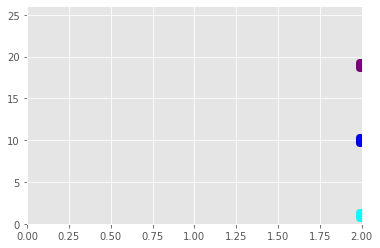

In [ ]:
color=["cyan","blue","purple","olive","pink","yellow"]
for i in range(ANTENNA_N):
  plt.scatter(x_final_position[i], y_final_position[i], color=color[i], linewidths =7 ,marker ="s")
plt.xlim(0, antennas_info_sizes[ANTENNA_N][0]-1)
plt.ylim(0, antennas_info_sizes[ANTENNA_N][1]-1)

plt.show()

assume that power adds up (SNR) -> reward 
qtable -> add the positions of new antenna and actions 
3 antennas optimization all area 


In [ ]:
antennas_object_heatmap={} #dict for antennas and their position 
maxsize_H=antennas_info_sizes[ANTENNA_N][0]
maxsize_W=antennas_info_sizes[ANTENNA_N][1]
SumOfSNR=np.zeros((1,maxsize_H*maxsize_W))
position=[]
for n in range(ANTENNA_N):
  antennas_object_heatmap[n]=antenna(x_final_position[n],y_final_position[n])
  #print(antennas_object_heatmap[n],maxsize_H,maxsize_W)
  #1d coordinate 
  position.append((antennas_info_sizes[n+1][0]*x_final_position[n])+ y_final_position[n])
  #print(position)
  ArrayOfSNR=measureSNR(antennas_object_heatmap[n],maxsize_H,maxsize_W,typeOfAntenna="omnidirectionnel")
  ## convert from magnitude to db 
  ArrayOfSNR=10*np.log10(ArrayOfSNR)
  #print(ArrayOfSNR)
  ArrayOfSNR=np.insert(ArrayOfSNR,position[n],0)
  #print(len(ArrayOfSNR))
  SumOfSNR=np.add(SumOfSNR,ArrayOfSNR)
  for i in range(len(SumOfSNR)):
    SumOfSNR[i]/=ANTENNA_N #average 
print(SumOfSNR) 

[[-54.47901122 -53.81593115 -53.27450297 -52.77336869 -52.21730713
  -51.56819244 -50.80954093 -46.32839268 -48.82728564 -47.79621009
  -46.96810948 -46.55488069 -46.32110602 -45.99063719 -45.45989447
  -44.69200484 -32.86306654 -42.09888065 -40.89190448 -40.469255
  -41.50279707 -43.33321757 -45.19353475 -46.85294262 -48.29907266
  -17.15275584 -49.74657508 -50.85572107 -54.07961117 -53.23193626
  -52.8506966  -52.49586489 -51.98955457 -51.3362889  -50.53020964
  -49.54108162 -48.3067295  -46.75613221 -45.37734666 -45.45025593
  -45.66377235 -45.49421991 -44.96664845 -44.07705813 -42.75118448
  -40.8228629  -38.10481884 -36.09467646 -38.676657   -41.97874418
  -44.51719276 -46.49707697 -48.1100002  -49.47013037 -50.64682562
  -53.80261322 -53.2080306  -53.07867678 -52.67812073 -52.11840469
  -51.41858472 -50.56371002 -49.50498416 -48.12278688 -46.03430531
  -45.4099467  -46.23565366 -46.31093082 -45.98184401 -45.31713632
  -44.28577749 -42.75826039 -40.39680322 -36.07990166 -36.354085

In [ ]:
import pandas as pd
import seaborn as sns
# sns.set()
snr_db=SumOfSNR
#for SNR in (SumOfSNR):
#  out_=10*np.log10(SNR)
#  snr_db.append(out_)
#print(snr_db)
# Build data
max_value_snr=np.max(snr_db)
min_value_snr=np.min(snr_db)
print(max_value_snr)
print(min_value_snr)

-17.152755836416578
-54.47901122380509


1


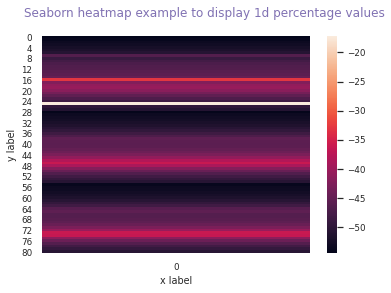

In [ ]:
## 1D heatmap
plt.figure()
plt.suptitle("Seaborn heatmap example to display 1d percentage values", color='m')
sns.set(font_scale=0.8)

print(len(snr_db))
snr_db=np.reshape(snr_db,((maxsize_H*maxsize_W),1)) ## size_w*size_h -1
ax = sns.heatmap(snr_db, vmin=min_value_snr, vmax=max_value_snr)
ax.set(xlabel='x label', ylabel='y label')

plt.show()

In [ ]:
#create 2D heatmap
rows=[]
#print(type(snr_db[0]))
# insert a value
#convert 2d array 
snr_db=np.reshape(snr_db,(maxsize_H,maxsize_W))
#snr_db=10*(np.log10(snr_db))
#print(snr_db)
for n in range(ANTENNA_N):
  #x=antennas_object_heatmap[n][0]
  #y=antennas_object_heatmap[n]
 
  snr_db[y_final_position[n]][x_final_position[n]]=0
#print(snr_db)
rows=snr_db
print(rows) 


IndexError: ignored

In [ ]:
#2D heatmap
plt.figure()
plt.suptitle("Seaborn heatmap example to display 2d percentage values", color='m')
sns.set(font_scale=0.8)

#print(type(rows))
#figure(figsize=(8, 6), dpi=80) # increase figure size 
rows_db=np.reshape(rows,(maxsize_H,maxsize_W))
ax = sns.heatmap(rows_db, vmin=min_value_snr, vmax=max_value_snr)
ax.set(xlabel='y label', ylabel='x label')


plt.show()
#figure(figsize=(8, 6), dpi=80) # increase figure size 
for n in range(ANTENNA_N):
  plt.scatter(x_final_position[n], y_final_position[n], color= "green", linewidths =10 ,marker ="s")
plt.xlim(0, maxsize_H-1)
plt.ylim(0, maxsize_W-1)
plt.show()